<center>
  <h1 style="font-family: Arial, sans-serif; font-weight: bold; font-size: 36px; color: #008CBA; text-shadow: 2px 2px #BDBDBD;">Classifying bees using Deep Learning - Results Analysis</h1>
  <h2 style="font-family: Arial, sans-serif; font-weight: bold; font-size: 36px; color: #008CBA; text-shadow: 2px 2px #BDBDBD;">Fabio PEREIRA DE ARAUJO</h2>
  <h3 style="font-family: Arial, sans-serif; font-weight: bold; font-size: 36px; color: #008CBA; text-shadow: 2px 2px #BDBDBD;">Second-year engineering school internship</h3>
</center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Imports

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
import tensorflow
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd

# Display
from IPython.display import Image, display
import matplotlib.cm as cm

# Variables

In [ ]:
IMG_SIZE = 224 #@param
BATCH_SIZE = 16 #@param
lr = 1e-3 #@param
train_path = "stage-2A/res/cap500/train" #@param
test_path = "stage-2A/res/cap500/test" #@param
path_weights = "stage-2A/res/poids-cap500/best_model_hierarchicaloss" #@param

# Téléchargement de la base de données

In [ ]:
!git clone https://github.com/fabiopereira59/abeilles-cap500

Cloning into 'abeilles-cap500'...
remote: Enumerating objects: 24878, done.
remote: Counting objects: 100% (6126/6126), done.
remote: Compressing objects: 100% (6121/6121), done.
remote: Total 24878 (delta 2), reused 6126 (delta 2), pack-reused 18752
Receiving objects: 100% (24878/24878), 242.93 MiB | 22.52 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (24081/24081), done.


In [ ]:
IMG_SIZE = 224
train_ds = keras.utils.image_dataset_from_directory(
    directory='abeilles-cap500/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE))

Found 14917 files belonging to 71 classes.


In [ ]:
IMG_SIZE = 224
train_ds = keras.utils.image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE))

In [ ]:
class_names = train_ds.class_names
nb_classes = len(class_names)

['Amegilla quadrifasciata', 'Andrena agilissima', 'Andrena bicolor', 'Andrena cineraria', 'Andrena clarkella', 'Andrena denticulata', 'Andrena flavipes', 'Andrena florea', 'Andrena fulva', 'Andrena gravida', 'Andrena haemorrhoa', 'Andrena hattorfiana', 'Andrena nigroaenea', 'Andrena nitida', 'Andrena nycthemera', 'Andrena thoracica', 'Andrena vaga', 'Andrena ventralis', 'Anthidiellum strigatum', 'Anthidium florentinum', 'Anthidium manicatum', 'Anthidium oblongatum', 'Anthidium septemspinosum', 'Anthophora bimaculata', 'Anthophora furcata', 'Anthophora plumipes', 'Apis mellifera', 'Bombus argillaceus', 'Bombus bohemicus', 'Bombus campestris', 'Bombus hortorum', 'Bombus humilis', 'Bombus hypnorum', 'Bombus lapidarius', 'Bombus lucorum', 'Bombus muscorum', 'Bombus pascuorum', 'Bombus pratorum', 'Bombus ruderatus', 'Bombus rupestris', 'Bombus sylvarum', 'Bombus terrestris lusitanicus', 'Bombus vestalis', 'Ceratina cucurbitina', 'Chelostoma florisomne', 'Colletes cunicularius', 'Colletes he

# Chargement du modèle

In [ ]:
# Création de l'architecture du modèle à utiser
conv_base = keras.applications.resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling=None,
    classes=nb_classes,
)

model = keras.Sequential(
    [
        conv_base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(nb_classes, kernel_regularizer=regularizers.L2(1e-4), activation='softmax')
    ]
)

# Chargement des poids
model.load_weights(path_weights)

model.compile(optimizers.SGD(learning_rate=lr, momentum=0.9), loss='categorical_crossentropy', metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

171458560/171446536 [==============================] - 1s 0us/step


# Chargement de l'ensemble de test

In [ ]:
test_ds_no_shuffle = keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE))

In [ ]:
nb_imgs_test = 1832

In [ ]:
x_test = np.zeros((nb_imgs_test, IMG_SIZE, IMG_SIZE, 3))
y_test = np.zeros((nb_imgs_test, nb_classes))

ind_data = 0
for bx, by in test_ds_no_shuffle.as_numpy_iterator():
  x_test[ind_data:ind_data+bx.shape[0]] = bx
  y_test[ind_data:ind_data+bx.shape[0]] = by

  ind_data += bx.shape[0]

x_test = tf.keras.applications.resnet.preprocess_input(x_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


abeilles-cap500/val/Amegilla quadrifasciata/Amegilla quadrifasciata12804.jpg


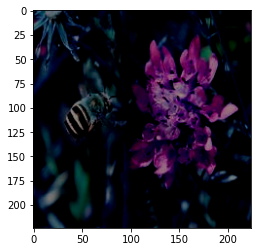

In [ ]:
plt.imshow(x_test[0].astype(int))
print(test_ds_no_shuffle.file_paths[0])

# Analyse des résultats : précision, sensibilité, F1_score

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
test_accuracy = Accuracy()

prediction = tensorflow.argmax(y_pred, axis=1, output_type=tensorflow.int32)
print(prediction)
test_accuracy(prediction, np.argmax(y_test, axis=1))

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

tf.Tensor([ 0  0  0 ... 70 70 70], shape=(1832,), dtype=int32)
Test set accuracy: 84.552%


In [ ]:
test_topk_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_k_categorical_accuracy", dtype=None)

test_topk_accuracy(y_test, y_pred)
print("Test set top 2 accuracy: {:.3%}".format(test_topk_accuracy.result()))

Test set top 2 accuracy: 93.504%


## Précision et Sensibilité

In [ ]:
true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(y_pred, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=5, output_dict=True)
print(report)

{'Amegilla quadrifasciata': {'precision': 0.72, 'recall': 0.9, 'f1-score': 0.7999999999999999, 'support': 20}, 'Andrena agilissima': {'precision': 0.9166666666666666, 'recall': 0.8461538461538461, 'f1-score': 0.8799999999999999, 'support': 13}, 'Andrena bicolor': {'precision': 1.0, 'recall': 0.6, 'f1-score': 0.7499999999999999, 'support': 10}, 'Andrena cineraria': {'precision': 0.9056603773584906, 'recall': 0.96, 'f1-score': 0.9320388349514563, 'support': 50}, 'Andrena clarkella': {'precision': 0.8260869565217391, 'recall': 0.7916666666666666, 'f1-score': 0.8085106382978724, 'support': 24}, 'Andrena denticulata': {'precision': 1.0, 'recall': 0.375, 'f1-score': 0.5454545454545454, 'support': 8}, 'Andrena flavipes': {'precision': 0.8095238095238095, 'recall': 0.68, 'f1-score': 0.7391304347826089, 'support': 25}, 'Andrena florea': {'precision': 0.9090909090909091, 'recall': 0.9523809523809523, 'f1-score': 0.9302325581395349, 'support': 21}, 'Andrena fulva': {'precision': 0.921568627450980

In [ ]:
df = pd.DataFrame(report).transpose()
display(df)
cm = confusion_matrix(true_labels, predicted_labels)

precision    recall  f1-score      support
Amegilla quadrifasciata   0.720000  0.900000  0.800000    20.000000
Andrena agilissima        0.916667  0.846154  0.880000    13.000000
Andrena bicolor           1.000000  0.600000  0.750000    10.000000
Andrena cineraria         0.905660  0.960000  0.932039    50.000000
Andrena clarkella         0.826087  0.791667  0.808511    24.000000
...                            ...       ...       ...          ...
Xylocopa valga            0.666667  0.750000  0.705882    16.000000
Xylocopa violacea         0.959184  0.940000  0.949495    50.000000
accuracy                  0.844432  0.844432  0.844432     0.844432
macro avg                 0.811392  0.775923  0.786027  1832.000000
weighted avg              0.847797  0.844432  0.842249  1832.000000

[74 rows x 4 columns]

In [ ]:
# Proportion de classes dont le f1_score est inférieur au f1_score moyen parmi 
# les classes dont le support est inférieur à un seui
df_without_average = df.head(nb_classes)
display(df_without_average)

averages = df.tail(3)
display(averages)

seuil = 15
selection = df_without_average.loc[df_without_average['support'] <= seuil]
display(selection)

nb_classes_under_represented = len(selection)

bad_f1_score = selection.loc[selection['f1-score'] <= averages.at['macro avg', 'f1-score']]
display(bad_f1_score)

nb_classes_bad_f1_score = len(bad_f1_score)
proportion = (nb_classes_bad_f1_score / nb_classes_under_represented) * 100
print("------- Proportion de : " + str(proportion) + " % -------")

precision    recall  f1-score  support
Amegilla quadrifasciata        0.720000  0.900000  0.800000     20.0
Andrena agilissima             0.916667  0.846154  0.880000     13.0
Andrena bicolor                1.000000  0.600000  0.750000     10.0
Andrena cineraria              0.905660  0.960000  0.932039     50.0
Andrena clarkella              0.826087  0.791667  0.808511     24.0
...                                 ...       ...       ...      ...
Rhodanthidium septemdentatum   0.857143  0.705882  0.774194     17.0
Rhodanthidium sticticum        0.909091  0.666667  0.769231     15.0
Sphecodes albilabris           0.970588  0.942857  0.956522     35.0
Xylocopa valga                 0.666667  0.750000  0.705882     16.0
Xylocopa violacea              0.959184  0.940000  0.949495     50.0

[71 rows x 4 columns]

precision    recall  f1-score      support
accuracy       0.844432  0.844432  0.844432     0.844432
macro avg      0.811392  0.775923  0.786027  1832.000000
weighted avg   0.847797  0.844432  0.842249  1832.000000

precision    recall  f1-score  support
Andrena agilissima         0.916667  0.846154  0.880000     13.0
Andrena bicolor            1.000000  0.600000  0.750000     10.0
Andrena denticulata        1.000000  0.375000  0.545455      8.0
Andrena gravida            1.000000  0.666667  0.800000      9.0
Andrena nycthemera         0.700000  0.636364  0.666667     11.0
Andrena thoracica          1.000000  0.714286  0.833333      7.0
Andrena ventralis          0.642857  0.692308  0.666667     13.0
Anthidiellum strigatum     0.666667  0.714286  0.689655     14.0
Anthidium oblongatum       0.562500  0.642857  0.600000     14.0
Anthidium septemspinosum   0.916667  0.785714  0.846154     14.0
Anthophora bimaculata      0.500000  0.416667  0.454545     12.0
Anthophora furcata         0.833333  0.555556  0.666667      9.0
Bombus bohemicus           0.733333  0.733333  0.733333     15.0
Bombus muscorum            0.555556  0.555556  0.555556      9.0
Bombus ruderatus           0.250000  0.222222  0.235294      9.0
Chelostoma florisomne      0.625000  0.714286  0.666667     14.0
Halictus rubicundus        0.714286  0.666667  0.689655     15.0
Halictus sexcinctus        0.714286  0.555556  0.625000      9.0
Heriades truncorum         0.666667  0.923077  0.774194     13.0
Hylaeus variegatus         0.764706  1.000000  0.866667     13.0
Lithurgus chrysurus        0.800000  0.363636  0.500000     11.0
Megachile centuncularis    0.900000  0.818182  0.857143     11.0
Melecta albifrons          0.692308  0.642857  0.666667     14.0
Nomada lathburiana         0.900000  0.900000  0.900000     10.0
Osmia aurulenta            0.555556  0.555556  0.555556      9.0
Osmia caerulescens         0.600000  0.545455  0.571429     11.0
Rhodanthidium sticticum    0.909091  0.666667  0.769231     15.0

precision    recall  f1-score  support
Andrena bicolor           1.000000  0.600000  0.750000     10.0
Andrena denticulata       1.000000  0.375000  0.545455      8.0
Andrena nycthemera        0.700000  0.636364  0.666667     11.0
Andrena ventralis         0.642857  0.692308  0.666667     13.0
Anthidiellum strigatum    0.666667  0.714286  0.689655     14.0
Anthidium oblongatum      0.562500  0.642857  0.600000     14.0
Anthophora bimaculata     0.500000  0.416667  0.454545     12.0
Anthophora furcata        0.833333  0.555556  0.666667      9.0
Bombus bohemicus          0.733333  0.733333  0.733333     15.0
Bombus muscorum           0.555556  0.555556  0.555556      9.0
Bombus ruderatus          0.250000  0.222222  0.235294      9.0
Chelostoma florisomne     0.625000  0.714286  0.666667     14.0
Halictus rubicundus       0.714286  0.666667  0.689655     15.0
Halictus sexcinctus       0.714286  0.555556  0.625000      9.0
Heriades truncorum        0.666667  0.923077  0.774194     13.0
Lithurgus chrysurus       0.800000  0.363636  0.500000     11.0
Melecta albifrons         0.692308  0.642857  0.666667     14.0
Osmia aurulenta           0.555556  0.555556  0.555556      9.0
Osmia caerulescens        0.600000  0.545455  0.571429     11.0
Rhodanthidium sticticum   0.909091  0.666667  0.769231     15.0

------- Proportion de : 74.07407407407408 % -------


# Analyse des confusions entre les classes

In [ ]:
# fp et fn : on a une classe à prédire et on détecte une autre classe
# => la classe à prédire = fn et l'autre classe comptée en fp
# précision => proportion de bonne détection
# sensibilité => mesure de combien on en a manqué
def confused_class(class_num, confusion_matrix, threshold=0):
  """
  Obtenir la liste des classes avec laquelle on a confondu la classe indiquee
  par class_num (numero de la classe).

  Arguments :
  - class_num : le numero de la classe
  - confusion_matrix : la matrice de confusion

  Retourne :
  false_positives : un dictionnaire contenant les faux positifs
  """

  class_name = class_names[class_num]

  indices_fp = np.argwhere(confusion_matrix[class_num,:] >= threshold)
  indices_fp = indices_fp.flatten()

  #indices_fn = np.argwhere(confusion_matrix[:,class_num] >= threshold)
  #indices_fn = indices_fn.flatten()

  false_positives = {}
  for i in indices_fp:
    if i != class_num:
      false_positives[class_names[i]] = confusion_matrix[class_num, i]


  #false_negatives = {}
  #for i in indices_fn:
  #  if i != class_num:
  #    false_negatives[class_names[i]] = confusion_matrix[i,class_num]  

  return false_positives

In [ ]:
def find_relevant_confusion(threshold, confusion_matrix):
  """
  Obtenir les classes avec lesquelles on a confondu l'entree du reseau.

  Arguments :
  - threshold : le nombre minimum de confusion avec une classe
  - confusion_matrix : la matrice de confusion des donnees

  Retourne :
  - dic_fp : un dictionnaire contenant : la classe "verite terrain" en clef, et
  en valeur, un dictionnaire contenant les classes avec lesquelles on a confondu
  la verite terrain (clef) et la nombre d'erreurs (valeur)
  """

  dic_fp = {}
  #dic_fn = {}

  for i in range(nb_classes):
    fp = confused_class(i, confusion_matrix, threshold=threshold)
    if (len(fp) > 0):
      dic_fp[class_names[i]] = fp
    #if (len(fn) > 0):
    #  dic_fn[class_names[i]] = fn
  return dic_fp

In [ ]:
fp = confused_class(36, cm, 1)
print(fp)

{'Andrena cineraria': 1, 'Dasypoda hirtipes': 1}


In [ ]:
import pprint
import pandas as pd
dic_fp = find_relevant_confusion(3, cm)
pprint.pprint(dic_fp, width=1)

dataframe = pd.DataFrame.from_dict(dic_fp)

{'Andrena clarkella': {'Colletes cunicularius': 3},
 'Anthidiellum strigatum': {'Anthidium florentinum': 3},
 'Bombus bohemicus': {'Bombus vestalis': 3},
 'Bombus lucorum': {'Bombus vestalis': 3},
 'Dasypoda hirtipes': {'Halictus scabiosae': 3}}


# Affichage d'images mal classées

In [ ]:
def get_misclassified_images(class_name, file_paths, y, y_pred):
  """
  Obtenir un dictionnaire des images mal classees ainsi que le label de la 
  classe avec laquelle on a fait la confusion.

  Arguments :
  - class_name : le nom de la classe souhaitée
  - x : les images d'entrees
  - y : les labels attendus
  - y_pred : les labels predits

  Retourne :
  - dic : un dictionnaire contenant en valeur le chemin de l'image mal classee
  et le label associe
  """

  num_class = class_names.index(class_name)
  index = np.where(y == num_class)

  dic = {}
  for i in index[0]:
    if (y_pred[i] != y[i]):
      dic[file_paths[i]] = class_names[y_pred[i]]
  
  return dic

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
def print_misclassified_images(dic, class_name, bad_label):
  """
  Permet d'afficher au plus 9 images mal classees dont le label est
  bad_label.

  Arguments :
  - dic : un dictionnaire contenant en clef les chemins d'acces aux images mal
  classees et en valeur, le mauvais label associe
  """

  fig = plt.figure(figsize=(20, 20))
  keys = list(dic.keys())
  print
  rows = 3
  columns = 3

  j = 1
  for i in range(len(keys)):
    image_path = keys[i]
    if (dic[image_path] == bad_label):
      fig.add_subplot(rows, columns, j)
      image = img.imread(image_path)
      plt.imshow(image)
      plt.axis('off') 
      plt.title("Attendu : " + class_name + " / Prédit : " + dic[image_path])
      j += 1
    if j == 9:
      break;

{'abeilles-cap500/test/Andrena clarkella/Andrena clarkella23650.jpg': 'Colletes '
                                                                      'cunicularius',
 'abeilles-cap500/test/Andrena clarkella/Andrena clarkella24935.jpg': 'Bombus '
                                                                      'sylvarum',
 'abeilles-cap500/test/Andrena clarkella/Andrena clarkella55642.jpg': 'Andrena '
                                                                      'nycthemera',
 'abeilles-cap500/test/Andrena clarkella/Andrena clarkella59390.jpeg': 'Colletes '
                                                                       'cunicularius',
 'abeilles-cap500/test/Andrena clarkella/andrena_m.jpg': 'Colletes '
                                                         'cunicularius'}


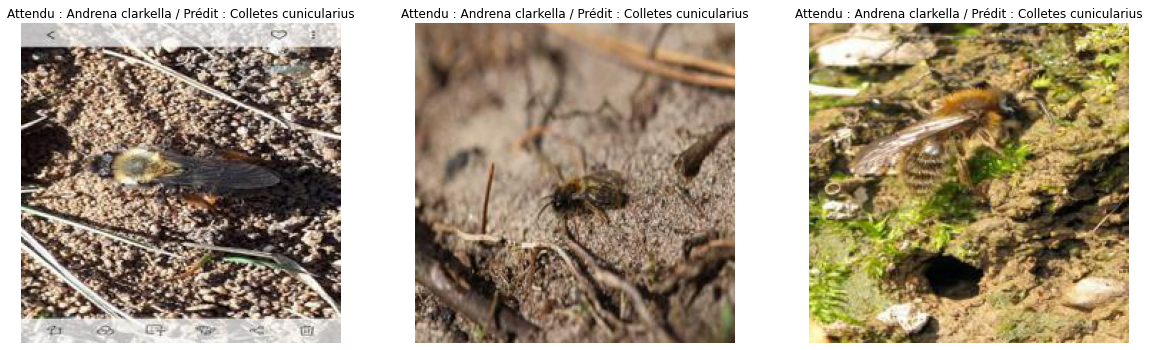

In [ ]:
true_y = np.argmax(y_test, axis=1)
predicted_y = np.argmax(y_pred, axis=1)
file_paths = test_ds_no_shuffle.file_paths
class_name = "Andrena clarkella"
mauvais_label = "Colletes cunicularius"

dic = get_misclassified_images(class_name, file_paths, true_y, predicted_y)
pprint.pprint(dic, width=1)
print_misclassified_images(dic, class_name, mauvais_label)

# Affichage d'heatmaps d'images mal classées - Méthode Grad-CAM

## Définition des fonctions pour les heatmaps



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 71)                145479    
                                                                 
Total params: 42,803,655
Trainable params: 42,698,311
Non-trainable params: 105,344
_________________________________________________________________


In [ ]:
last_conv_layer_name = "resnet101"

# The local path to our target image
#img_path = "abeilles-cap500/test/Amegilla quadrifasciata/LMDI_amegilla.jpg"

#display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer("global_average_pooling2d").input, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Prepare image
#img_array = tf.keras.applications.resnet.preprocess_input(get_img_array(img_path, size=(IMG_SIZE,IMG_SIZE)))

# Remove last layer's softmax
#model.layers[-1].activation = None


# Generate class activation heatmap
#heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
#plt.matshow(heatmap)
#plt.show()

In [ ]:
from scipy import ndimage, misc
def save_and_display_gradcam(img_path, heatmap, cam_path="/content/drive/MyDrive/img.jpg", alpha=0.4, seuil_heatmap=0, affichage_contour=True, affichage_heatmap=False):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.where(heatmap > seuil_heatmap, heatmap, 0)
    #print("heatmap")
    #print(heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    #print("jeat_heatmap")
    #print(jet_heatmap)

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    #print(jet_heatmap)
    superimposed_img = np.copy(img)
    red = np.zeros((IMG_SIZE, IMG_SIZE))
    for i in range(IMG_SIZE):
      for j in range(IMG_SIZE):
        # Partie la plus chaude de la heatmap
        if (not(affichage_heatmap)):
          if (jet_heatmap[i][j][0] > seuil_heatmap):
            superimposed_img[i][j] = jet_heatmap[i][j] * alpha + img[i][j]
            red[i][j] = 1
        else:
          superimposed_img[i][j] = jet_heatmap[i][j] * alpha + img[i][j]
          red[i][j] = 1
    
    # Affichage uniquement du contour
    if (affichage_contour):
      contour = np.copy(img)
      for i in range(1, IMG_SIZE-1):
        for j in range(1, IMG_SIZE-1):
          if (red[i][j] == 1):
            sub_red = red[i-1:i+2, j-1:j+2]
            nb_ones = np.sum(sub_red)
            if (nb_ones <= 6):
              contour[i][j] = superimposed_img[i][j]
      superimposed_img = contour

    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    return superimposed_img

#save_and_display_gradcam(img_path, heatmap)

## Affichage des heatmaps sur des images mal classées

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
def print_misclassified_images_heatmaps(dic, class_name, bad_label, alpha=1.2, seuil_heatmap=0, affichage_contour=True, affichage_heatmap=False):
  """
  Permet d'afficher au plus 9 heatmaps d'images mal classees dont le label est
  bad_label.

  Arguments :
  - dic : un dictionnaire contenant en clef les chemins d'acces aux images mal
  classees et en valeur, le mauvais label associe
  """

  fig = plt.figure(figsize=(20, 20))
  keys = list(dic.keys())
  print
  rows = 3
  columns = 3

  j = 1
  for i in range(len(keys)):
    image_path = keys[i]
    if (dic[image_path] == bad_label):
      fig.add_subplot(rows, columns, j)
      image_array = tf.keras.applications.resnet.preprocess_input(get_img_array(image_path, size=(IMG_SIZE,IMG_SIZE)))
      heatmap = make_gradcam_heatmap(image_array, model, last_conv_layer_name)
      superimposed_img = save_and_display_gradcam(image_path, heatmap, alpha=alpha, seuil_heatmap=seuil_heatmap, affichage_contour=affichage_contour, affichage_heatmap=affichage_heatmap)
      plt.imshow(superimposed_img)
      plt.axis('off') 
      plt.title("Attendu : " + class_name + " / Prédit : " + dic[image_path])
      j += 1
    if j == 9:
      break;

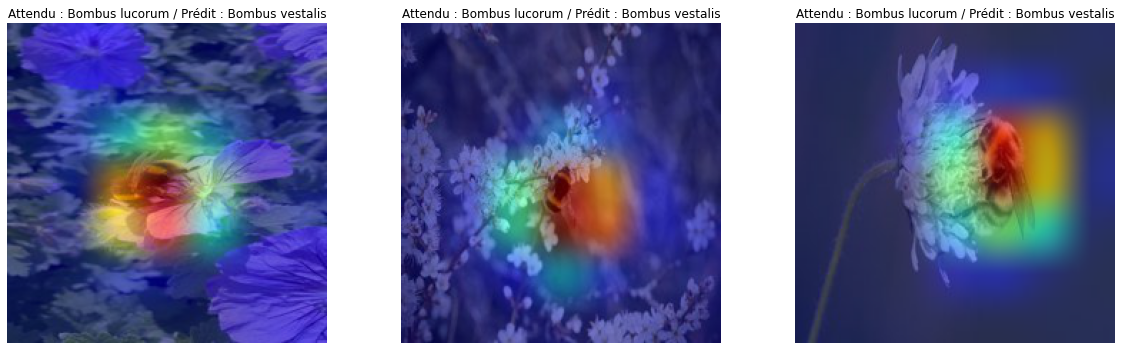

In [ ]:
# Remove last layer's softmax
model.layers[-1].activation = None

class_name = "Bombus lucorum"
mauvais_label = "Bombus vestalis"
dic = get_misclassified_images(class_name, file_paths, true_y, predicted_y)
#pprint.pprint(dic, width=1)

print_misclassified_images_heatmaps(dic, class_name, mauvais_label, seuil_heatmap=0, affichage_contour=False, affichage_heatmap=True)

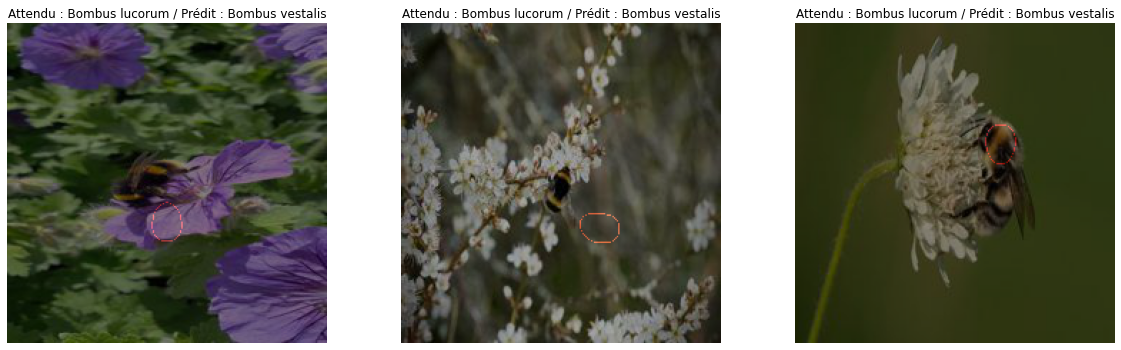

In [ ]:
class_name = "Bombus lucorum"
mauvais_label = "Bombus vestalis"
dic = get_misclassified_images(class_name, file_paths, true_y, predicted_y)
#pprint.pprint(dic, width=1)

print_misclassified_images_heatmaps(dic, class_name, mauvais_label, seuil_heatmap=200, affichage_contour=True, affichage_heatmap=False)

# Affichage des heatmaps sur des images bien classées

In [ ]:
def get_classified_images(class_name, file_paths, y, y_pred):
  num_class = class_names.index(class_name)
  index = np.where(y == num_class)

  dic = {}
  for i in index[0]:
    if (y_pred[i] == y[i]):
      dic[file_paths[i]] = class_names[y_pred[i]]
  
  return dic

In [ ]:
class_name = "Bombus humilis"
dic_apis_mellifera = get_classified_images(class_name, file_paths, true_y, predicted_y)
print(dic_apis_mellifera)

{'abeilles-cap500/test/Bombus humilis/Bombus humilis poss 1.5 Illkirch Heyssel 6 07 2019 IMG_4706.jpg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis13166.jpeg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis1623.jpeg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis34963.jpg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis56058.jpg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis62714.jpeg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis68982.jpeg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis73949.jpg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis78607.jpg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis84249.jpg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis85482.jpg': 'Bombus humilis', 'abeilles-cap500/test/Bombus humilis/Bombus humilis89529.jpg': 'B

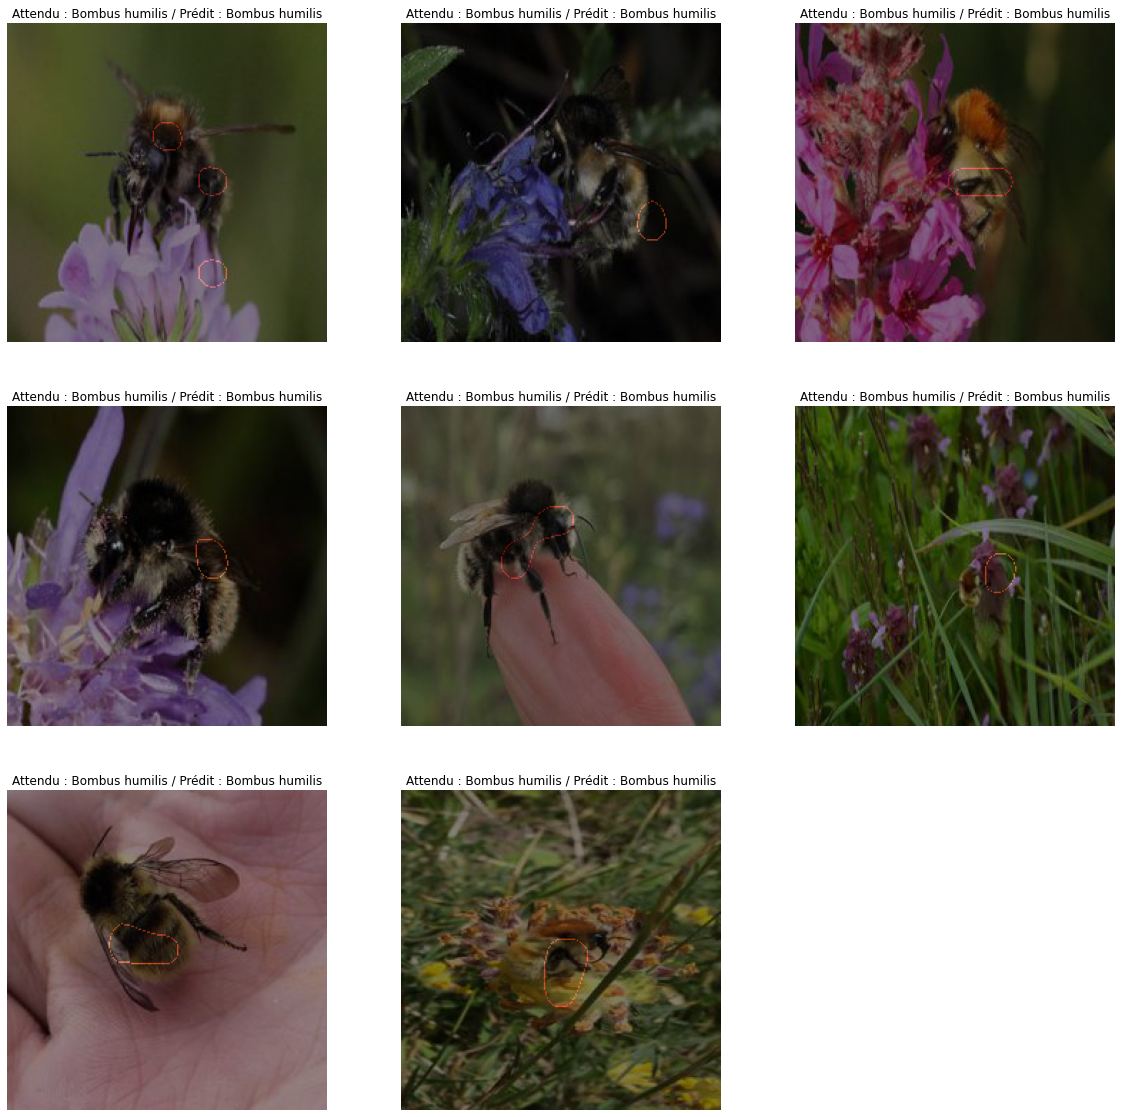

In [ ]:
print_misclassified_images_heatmaps(dic_apis_mellifera, class_name, class_name, seuil_heatmap=200, affichage_contour=True, affichage_heatmap=False)

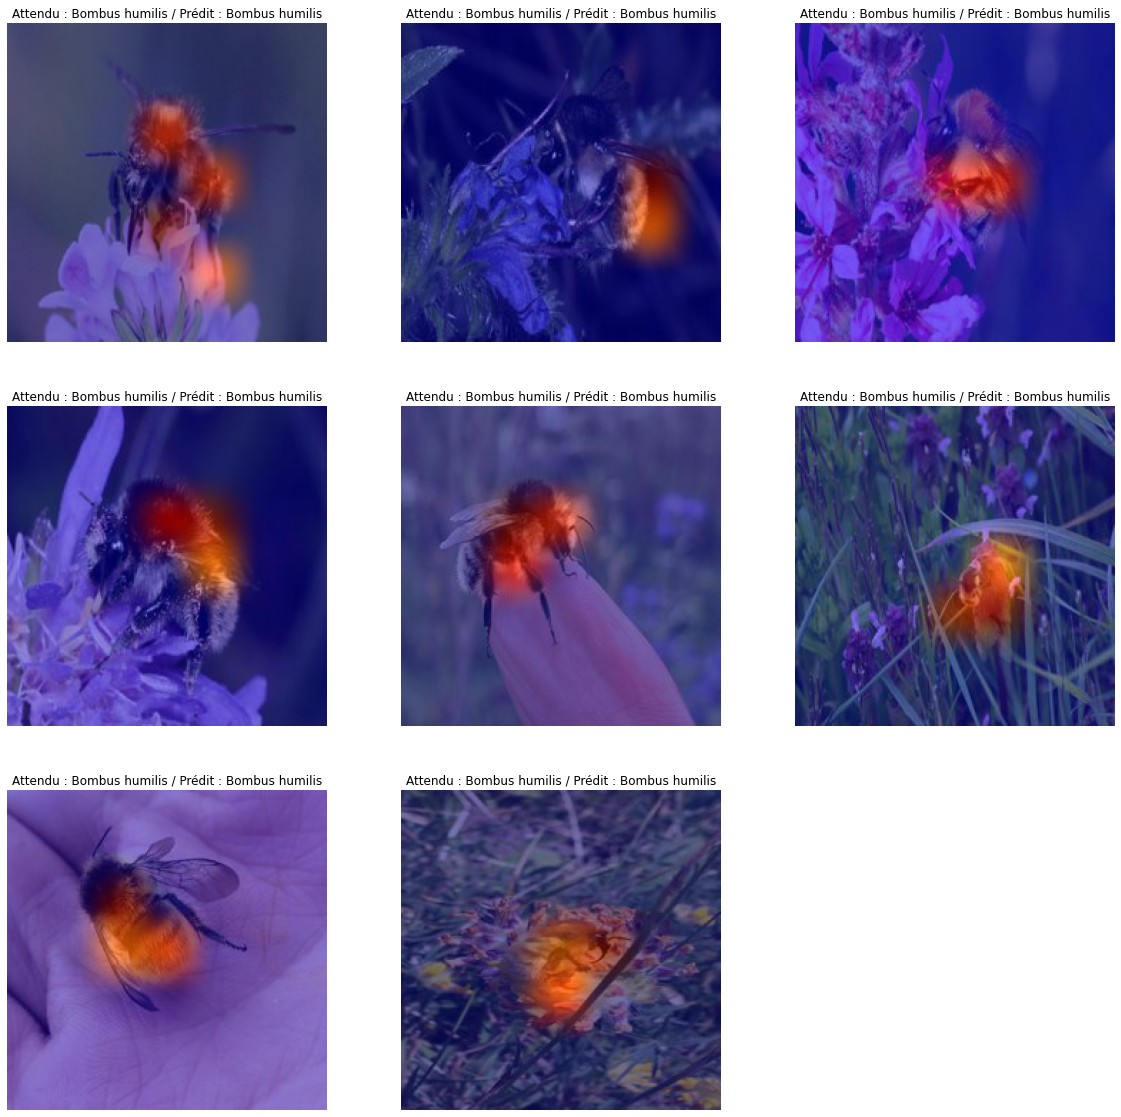

In [ ]:
print_misclassified_images_heatmaps(dic_apis_mellifera, class_name, class_name, seuil_heatmap=200, affichage_contour=False, affichage_heatmap=True)

# Sauvegarde des heatmaps des images de l'ensemble de test

In [ ]:
true_y.shape[0]
print(true_y)

[ 0  0  0 ... 70 70 70]


In [ ]:
import numpy as np
import os
from PIL import Image
path = os.getcwd()
path = path + ""
print(path)

/content/drive/MyDrive/Stage2A/cap500/ResNet101/ResNet101_Sequence/TestHeatmaps


In [ ]:
len(class_names)

71

In [ ]:
def create_directory(directory_path, class_names):
  
  nb_especes = len(class_names)

  for i in range(nb_especes):
    species = class_names[i]
    os.mkdir(directory_path + "/" + species)
    os.mkdir(directory_path + "/" + species + "/images_bien_classees")
    os.mkdir(directory_path + "/" + species + "/images_bien_classees" + "/heatmaps")
    os.mkdir(directory_path + "/" + species + "/images_bien_classees" + "/contours200")
    os.mkdir(directory_path + "/" + species + "/images_bien_classees" + "/contours220")
    os.mkdir(directory_path + "/" + species + "/images_mal_classees")
    os.mkdir(directory_path + "/" + species + "/images_mal_classees" + "/heatmaps")
    os.mkdir(directory_path + "/" + species + "/images_mal_classees" + "/contours200")
    os.mkdir(directory_path + "/" + species + "/images_mal_classees" + "/contours220")

In [ ]:
create_directory(path, class_names)

In [ ]:
file_paths[0]

'abeilles-cap500/test/Amegilla quadrifasciata/Amegilla quadrifasciata15848.jpeg'

In [ ]:
def save_heatmaps(class_names, file_paths, y, y_pred):

  nb_images = y.shape[0]

  for i in range(nb_images):

    species = class_names[y[i]]
    image_path = file_paths[i]
    image_name = os.path.basename(image_path)
    image_array = tf.keras.applications.resnet.preprocess_input(get_img_array(image_path, size=(IMG_SIZE,IMG_SIZE)))
    heatmap = make_gradcam_heatmap(image_array, model, last_conv_layer_name)
    # Calcul heatmap
    heatmap_image = save_and_display_gradcam(image_path, heatmap, alpha=1.2, seuil_heatmap=200, affichage_contour=False, affichage_heatmap=True)
    # Calcul contour
    contour_image200 = save_and_display_gradcam(image_path, heatmap, alpha=1.2, seuil_heatmap=200, affichage_contour=True, affichage_heatmap=False)
    contour_image220 = save_and_display_gradcam(image_path, heatmap, alpha=1.2, seuil_heatmap=220, affichage_contour=True, affichage_heatmap=False)
    if (y[i] == y_pred[i]):
      name_to_save = path + "/" + species + "/" + "images_bien_classees"
      #print(name_to_save)
      heatmap_image.save(name_to_save + "/" + "heatmaps" + "/" + "heatmap_" + image_name)
      contour_image200.save(name_to_save + "/" + "contours200" + "/" + "contour200_" + image_name)
      contour_image220.save(name_to_save + "/" + "contours220" + "/" + "contour220_" + image_name)
    else:
      name_to_save = path + "/" + species + "/" + "images_mal_classees"
      bad_species = class_names[y_pred[i]]
      #print(name_to_save)
      #print(bad_species)
      heatmap_image.save(name_to_save + "/" + "heatmaps" + "/" + "heatmap_predit_" + bad_species + "_" + image_name)
      contour_image200.save(name_to_save + "/" + "contours200" + "/" + "contour200_predit_" + bad_species + "_" + image_name)
      contour_image220.save(name_to_save + "/" + "contours220" + "/" + "contour220_predit_" + bad_species + "_" + image_name)

In [ ]:
save_heatmaps(class_names, file_paths, true_y, predicted_y)